In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from matplotlib.ticker import FormatStrFormatter

### Podstawowe funkcje

In [2]:
n_repeats = 10

In [3]:
def get_dset(filename, label_name, col_names=None):
    dset = pd.read_csv(f'data/{filename}', header=None if col_names else 0)
    
    if col_names is not None:
        dset.columns = col_names

    X = dset.drop(label_name, axis=1).values
    y = dset[label_name]

    return X, y

def get_seeds_dset(filename, label_name, col_names=None):
    dset = pd.read_csv(f'data/{filename}', sep=',', header=None if col_names else 0)

    if col_names is not None:
        dset.columns = col_names

    X = dset.drop(label_name, axis=1).values
    y = dset[label_name]

    return X, y


Załadowanie zbiorów danych

In [4]:
wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
                  'Alcalinity of ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 
                  'Color intensity', 'Hue', 
                  'OD280/OD315 of diluted wines', 'Proline']

glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
                  'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']

seeds_col_names = ['area', 'perimeter', 'compactness', 
                          'length_of_kernel', 
                          'width_of_kernel', 
                          'asymmetry_coefficient', 
                          'length_of_kernel_groove', 
                          'Type']


X_iris, y_iris = get_dset('iris.csv', 'variety')
X_wine, y_wine = get_dset('wine.data', 'Class identifier', wine_col_names)
X_glass, y_glass = get_dset('glass.data', 'type', glass_col_names)
X_seeds, y_seeds = get_seeds_dset('seeds_dataset.txt', 'Type', seeds_col_names)


Eksperymenty

In [5]:
n_samples = 10

In [6]:
def experiment(X, y, model, seed, test_size=0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    return acc, f1

In [7]:
def show_plots(acc_to_plot, f1_to_plot, labels, param):
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    ax[0].boxplot(f1_to_plot)
    ax[1].boxplot(acc_to_plot)

    ax[0].set_title('F1 score')
    ax[1].set_title('Accuracy')
    for i in range(2):
        #ax[i].legend()
        ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax[i].set_xticks(np.arange(1, len(labels) + 1, 1), labels)
        ax[i].set_xlabel(f'Wartość {param}')
        ax[i].set_ylabel(f'Wartość metryki')
    plt.show()

In [8]:
base_max_depth_tree = 6
base_max_features_tree = 'auto'

decision_tree_grid = {
    'max_depth': range(1, 16),
    'max_features': np.arange(0.05, 1.05, 0.05),
}

def base_tree(X, y,
              max_depth=base_max_depth_tree,
              max_features=base_max_features_tree):
    
    accuracies = []
    f1_scores = []
    
    for i in range(n_samples):
        model = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features)
        
        acc, f1 = experiment(X, y, model, seed=i)
        accuracies.append(acc)
        f1_scores.append(f1)
    
    return accuracies, f1_scores

In [9]:
base_n_estimators_bagging = 25
base_max_samples_bagging = 1.0
base_max_features_bagging = 1.0
base_bootstrap_bagging = True

def bagging(X, y,
            n_estimators=base_n_estimators_bagging, 
            max_samples=base_max_samples_bagging, 
            max_features=base_max_features_bagging, 
            bootstrap=base_bootstrap_bagging):
    
    accuracies = []
    f1_scores = []
    
    for i in range(n_samples):
        model = BaggingClassifier(n_estimators=n_estimators, 
                               max_samples=max_samples, 
                               max_features=max_features, 
                               bootstrap=bootstrap)
        
        acc, f1 = experiment(X, y, model, seed=i)
        accuracies.append(acc)
        f1_scores.append(f1)
    
    return accuracies, f1_scores

In [10]:
base_n_estimators_adaboost = 25
base_learning_rate_adaboost = 1.0

def boosting(X, y,
            n_estimators=base_n_estimators_adaboost, 
            learning_rate=base_learning_rate_adaboost):
    
    accuracies = []
    f1_scores = []
    
    for i in range(n_samples):
        model = AdaBoostClassifier(n_estimators=n_estimators,
                                  learning_rate=learning_rate)
        
        acc, f1 = experiment(X, y, model, seed=i)
        accuracies.append(acc)
        f1_scores.append(f1)
    
    return accuracies, f1_scores

In [11]:
base_n_estimators_forest = 25
base_max_features_forest = 'sqrt'
base_max_samples_forest = None
base_max_depth_forest = None

def random_forest(X, y,
                  n_estimators=base_n_estimators_forest,
                  max_features=base_max_features_forest,
                  max_samples=base_max_samples_forest,
                  max_depth=base_max_depth_forest):
    accuracies = []
    f1_scores = []
    
    for i in range(n_samples):
        model = RandomForestClassifier(n_estimators=n_estimators,
                                      max_features=max_features,
                                      max_samples=max_samples,
                                      max_depth=max_depth)
        
        acc, f1 = experiment(X, y, model, seed=i)
        accuracies.append(acc)
        f1_scores.append(f1)
    
    return accuracies, f1_scores

In [12]:
def run_tree_experiments(X, y):
    max_depth_l = range(1, 16)
    max_features_l = range(1, X.shape[1])

    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for max_depth in max_depth_l:
        accuracies, f1_scores = base_tree(X, y, max_depth=max_depth)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(max_depth)

    print(f'Max depth experiment. Other config: Max_features: {base_max_features_tree}')
    
    best_max_depth = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'Max depth')
   
    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for max_features in max_features_l:
        accuracies, f1_scores = base_tree(X, y, max_depth=best_max_depth, max_features=max_features)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(max_features)

    print(f'Max_features experiment. Other config: max_depth: {best_max_depth}')
    best_max_features = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'Max features')
    
    return best_max_depth, best_max_features
    

In [13]:
def run_bagging_experiments(X, y):
    n_estimators_l = [1, 2, 5, 10, 15, 25, 50, 75, 100]
    max_samples_l = np.arange(0.05, 1.05, 0.05)
    max_features_l = range(1, X.shape[1])
    bootstrap_l = [False, True]

    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for n_estimators in n_estimators_l:
        accuracies, f1_scores = bagging(X, y, n_estimators=n_estimators)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(n_estimators)

    print(f'N estimators experiment. Other config: max_samples: {base_max_samples_bagging}, max_features: {base_max_features_bagging}, bootstrap: {base_bootstrap_bagging}')
    best_n_estimators = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'N estimators')
    
    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for max_samples in max_samples_l:
        accuracies, f1_scores = bagging(X, y, n_estimators=best_n_estimators,
                                        max_samples=max_samples)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(round(max_samples, 2))

    print(f'Max_samples experiment. Other config: n_estimators: {best_n_estimators}, max_features: {base_max_features_bagging}, bootstrap: {base_bootstrap_bagging}')
    best_max_samples = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'Max samples')
    
    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for max_features in max_features_l:
        accuracies, f1_scores = bagging(X, y, 
                                        n_estimators=best_n_estimators,
                                        max_samples=best_max_samples,
                                        max_features=max_features)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(max_features)

    print(f'Max_features experiment. Other config: n_estimators: {best_n_estimators}, max_samples: {best_max_samples}, bootstrap: {base_bootstrap_bagging}')
    best_max_features = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'Max features')
    
    
    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for bootstrap in bootstrap_l:
        accuracies, f1_scores = bagging(X, y, 
                                        n_estimators=best_n_estimators,
                                        max_samples=best_max_samples,
                                        max_features=best_max_features,
                                        bootstrap=bootstrap)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(bootstrap)

    print(f'Bootstrap experiment. Other config: n_estimators: {best_n_estimators}, max_samples: {best_max_samples}, max_features: {best_max_features}')
    best_bootstrap = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'Bootstrap')
    
    return best_n_estimators, best_max_samples, best_max_features, best_bootstrap

In [14]:
def run_boosting_experiments(X, y):
    n_estimators_l = [1, 2, 5, 10, 15, 25, 50, 75, 100]
    learning_rates_l = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1]

    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for n_estimators in n_estimators_l:
        accuracies, f1_scores = boosting(X, y, n_estimators=n_estimators)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(n_estimators)

    print(f'N estimators experiment. Other config: learning_rate: {base_learning_rate_adaboost}')
    best_n_estimators = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'N estimators')
    
    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for learning_rate in learning_rates_l:
        accuracies, f1_scores = boosting(X, y, n_estimators=best_n_estimators,
                                         learning_rate=learning_rate)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(learning_rate)

    print(f'Learning rate experiment. Other config: n_estimators: {best_n_estimators}')
    best_learning_rate = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'Learning rate')
    
    return best_n_estimators, best_learning_rate
    

In [15]:
def run_forest_experiments(X, y):
    n_estimators_l = [1, 2, 5, 10, 15, 25, 50, 75, 100]
    max_features_l = np.arange(0.05, 1.05, 0.05)
    max_samples_l = np.arange(0.05, 1.05, 0.05)
    max_depth_l = range(1, X.shape[1])
    
    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for n_estimators in n_estimators_l:
        accuracies, f1_scores = random_forest(X, y, n_estimators=n_estimators)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(n_estimators)

    print(f'N estimators experiment. Other config: max_features: {base_max_features_forest}, max_samples: {base_max_samples_forest}, max_depth: {base_max_depth_forest}')
    best_n_estimators = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'N estimators')
    
    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for max_features in max_features_l:
        accuracies, f1_scores = random_forest(X, y, 
                                              n_estimators=best_n_estimators,
                                              max_features=max_features)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(round(max_features, 2))

    print(f'Max features experiment. Other config: n estimators: {best_n_estimators}, max_samples: {base_max_samples_forest}, max_depth: {base_max_depth_forest}')
    best_max_features = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'Max features')
    
    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for max_samples in max_samples_l:
        accuracies, f1_scores = random_forest(X, y, 
                                              n_estimators=best_n_estimators,
                                              max_features=best_max_features,
                                              max_samples=max_samples)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(round(max_samples, 2))

    print(f'Max samples experiment. Other config: n estimators: {best_n_estimators}, max_features: {best_max_features}, max_depth: {base_max_depth_forest}')
    best_max_samples = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'Max samples')
    
    labels = []
    acc_to_plot = []
    f1_to_plot = []
    for max_depth in max_depth_l:
        accuracies, f1_scores = random_forest(X, y, 
                                              n_estimators=best_n_estimators,
                                              max_features=best_max_features,
                                              max_samples=best_max_samples,
                                              max_depth=max_depth)
        acc_to_plot.append(accuracies)
        f1_to_plot.append(f1_scores)
        labels.append(max_depth)

    print(f'Max depth experiment. Other config: n estimators: {best_n_estimators}, max_features: {best_max_features}, max_samples: {best_max_samples}')
    best_max_depth = labels[np.argmax([np.mean(x) for x in f1_to_plot])]
    show_plots(acc_to_plot, f1_to_plot, labels, 'Max depth')
    
    return best_n_estimators, best_max_features, best_max_samples, best_max_depth

In [16]:
def comparison(X, y,
              best_max_depth_tree, best_max_features_tree,
              best_n_estimators_bag, best_max_samples_bag, best_max_features_bag, best_bootstrap_bag,
              best_n_estimators_boost, best_learning_rate_boost,
              best_n_estimators_forest, best_max_features_forest, best_max_samples_forest, best_max_depth_forest
              ):
    
    labels = []
    acc_to_plot = []
    f1_to_plot = []

    accuracies, f1_scores = base_tree(X, y, best_max_depth_tree, best_max_features_tree)
    acc_to_plot.append(accuracies)
    f1_to_plot.append(f1_scores)
    labels.append('Base tree')

    accuracies, f1_scores = bagging(X, y, best_n_estimators_bag, best_max_samples_bag, best_max_features_bag, best_bootstrap_bag)
    acc_to_plot.append(accuracies)
    f1_to_plot.append(f1_scores)
    labels.append('Bagging')
    
    accuracies, f1_scores = boosting(X, y, best_n_estimators_boost, best_learning_rate_boost)
    acc_to_plot.append(accuracies)
    f1_to_plot.append(f1_scores)
    labels.append('Boosting')
    
    accuracies, f1_scores = random_forest(X, y, best_n_estimators_forest, best_max_features_forest, best_max_samples_forest, best_max_depth_forest)
    acc_to_plot.append(accuracies)
    f1_to_plot.append(f1_scores)
    labels.append('Random forest')
    
    show_plots(acc_to_plot, f1_to_plot, labels, 'Porównanie modeli')

## IRIS

Max depth experiment. Other config: Max_features: auto


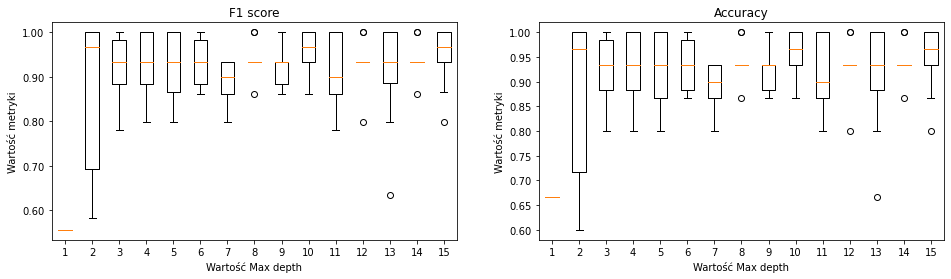

Max_features experiment. Other config: max_depth: 10


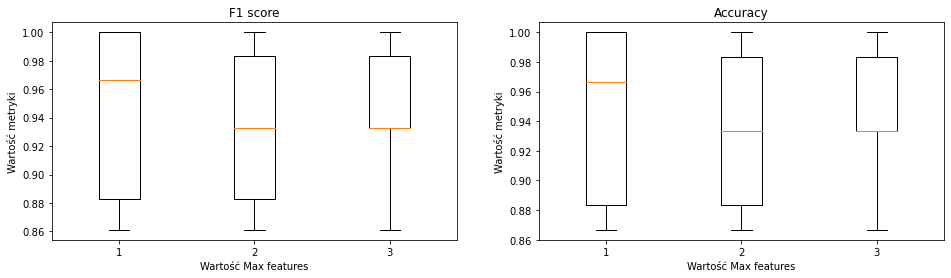

In [17]:
best_max_depth_tree, best_max_features_tree = run_tree_experiments(X_iris, y_iris)

N estimators experiment. Other config: max_samples: 1.0, max_features: 1.0, bootstrap: True


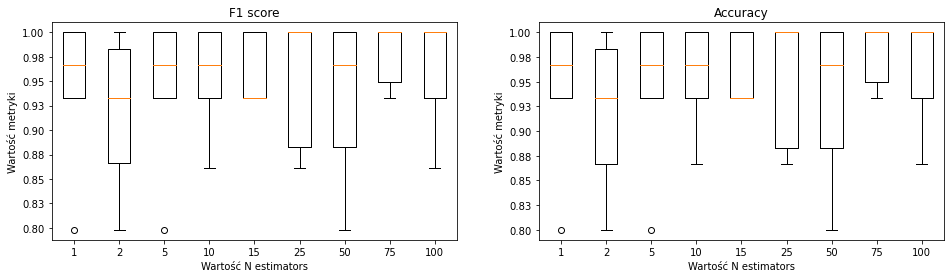

Max_samples experiment. Other config: n_estimators: 75, max_features: 1.0, bootstrap: True


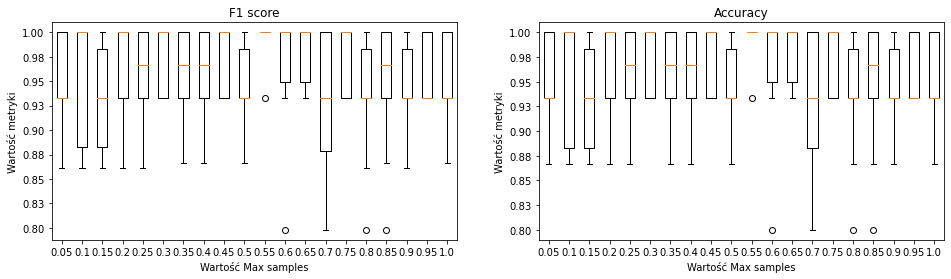

Max_features experiment. Other config: n_estimators: 75, max_samples: 0.55, bootstrap: True


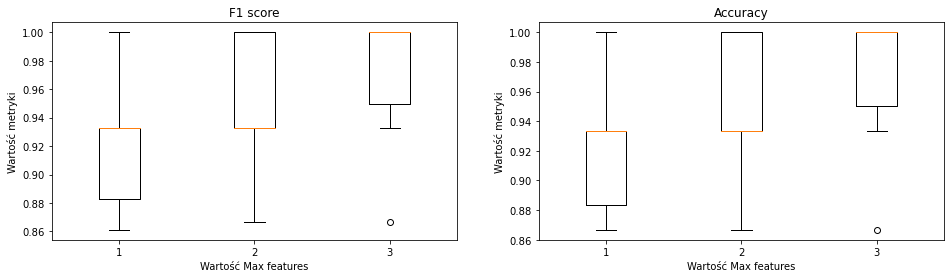

Bootstrap experiment. Other config: n_estimators: 75, max_samples: 0.55, max_features: 3


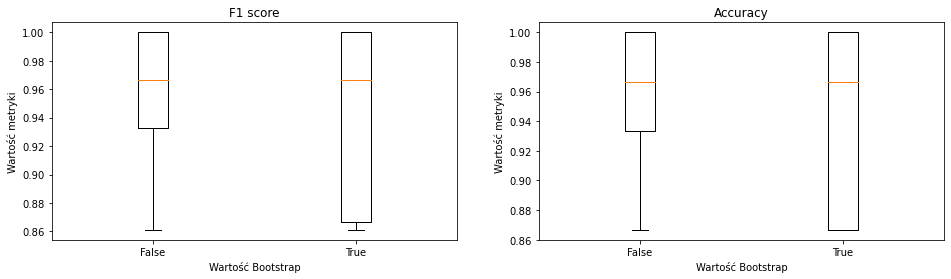

In [18]:
best_n_estimators_bag, best_max_samples_bag, best_max_features_bag, best_bootstrap_bag = run_bagging_experiments(X_iris, y_iris)

N estimators experiment. Other config: learning_rate: 1.0


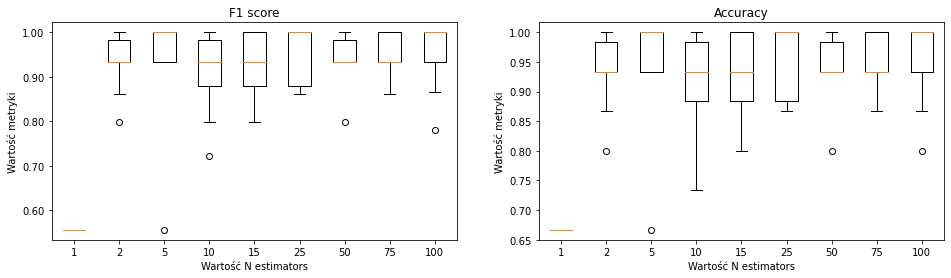

Learning rate experiment. Other config: n_estimators: 25


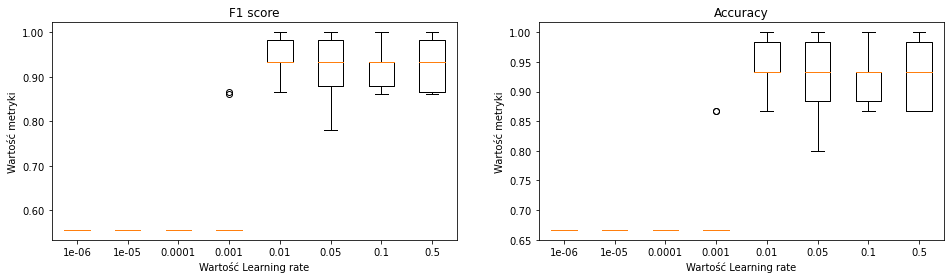

In [19]:
best_n_estimators_boost, best_learning_rate_boost = run_boosting_experiments(X_iris, y_iris)

N estimators experiment. Other config: max_features: sqrt, max_samples: None, max_depth: None


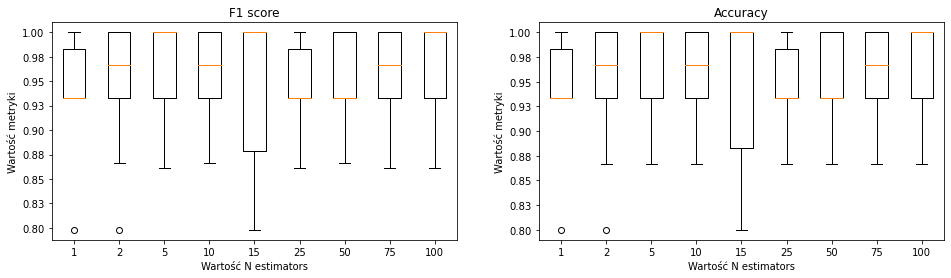

Max features experiment. Other config: n estimators: 100, max_samples: None, max_depth: None


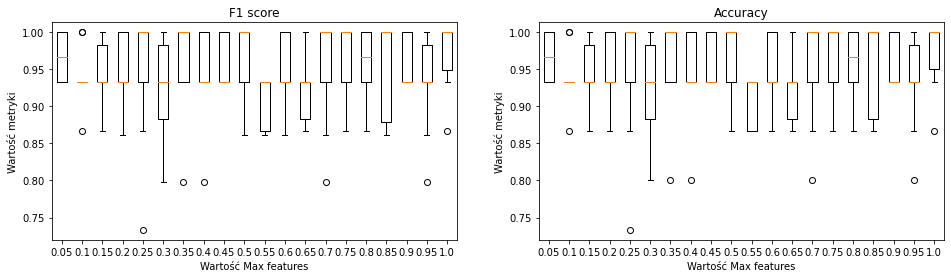

Max samples experiment. Other config: n estimators: 100, max_features: 1.0, max_depth: None


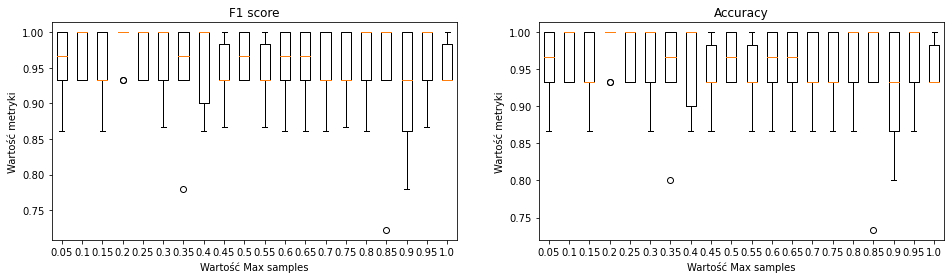

Max depth experiment. Other config: n estimators: 100, max_features: 1.0, max_samples: 0.2


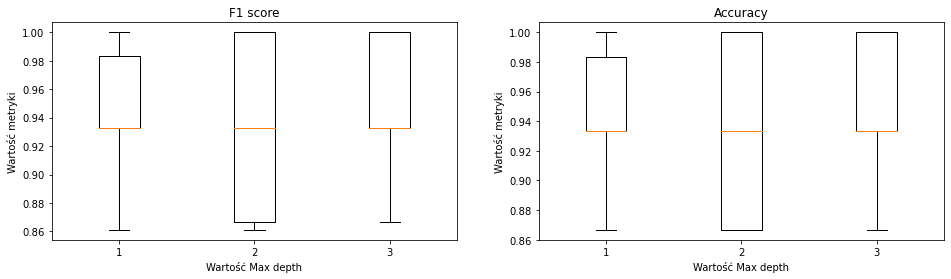

In [20]:
best_n_estimators_forest, best_max_features_forest, best_max_samples_forest, best_max_depth_forest = run_forest_experiments(X_iris, y_iris)

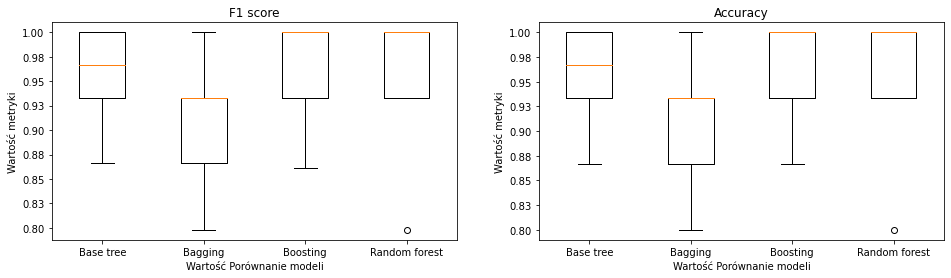

In [21]:
comparison(X_iris, y_iris,
              best_max_depth_tree, best_max_features_tree,
              best_n_estimators_bag, best_max_samples_bag, best_max_features_bag, best_bootstrap_bag,
              best_n_estimators_boost, best_learning_rate_boost,
              best_n_estimators_forest, best_max_features_forest, best_max_samples_forest, best_max_depth_forest
              )

# WINE

## Bazowy

Max depth experiment. Other config: Max_features: auto


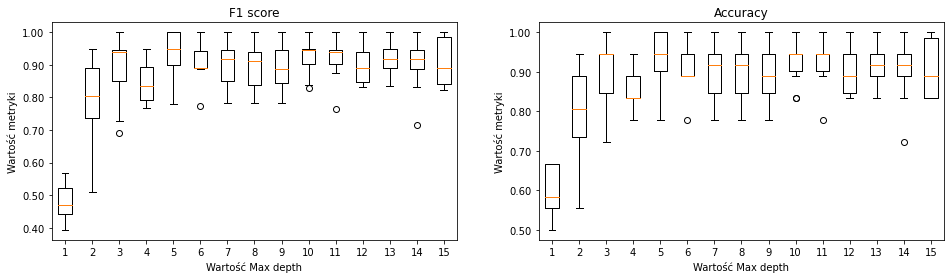

Max_features experiment. Other config: max_depth: 5


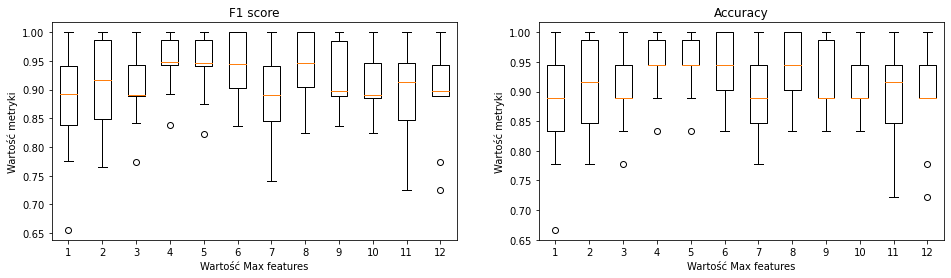

In [22]:
best_max_depth_tree, best_max_features_tree = run_tree_experiments(X_wine, y_wine)

## Bagging

N estimators experiment. Other config: max_samples: 1.0, max_features: 1.0, bootstrap: True


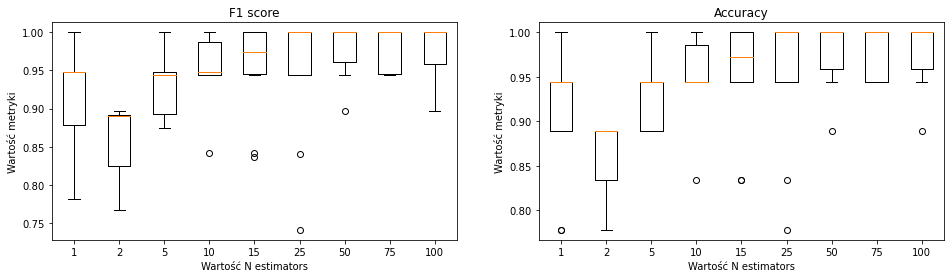

Max_samples experiment. Other config: n_estimators: 50, max_features: 1.0, bootstrap: True


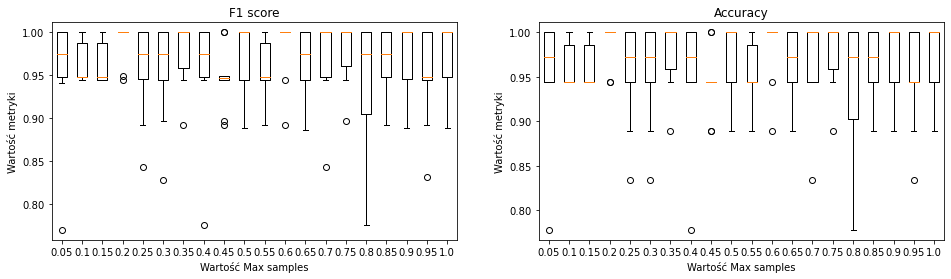

Max_features experiment. Other config: n_estimators: 50, max_samples: 0.2, bootstrap: True


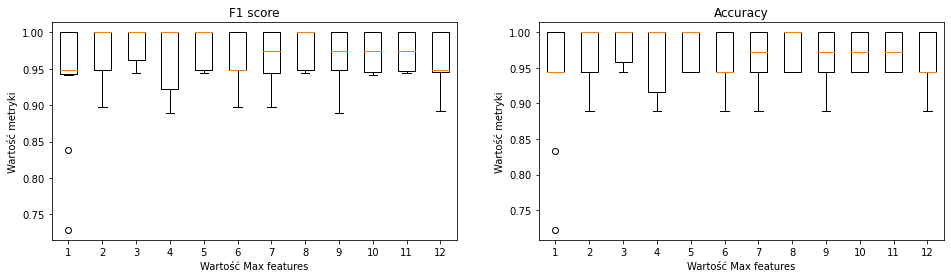

Bootstrap experiment. Other config: n_estimators: 50, max_samples: 0.2, max_features: 3


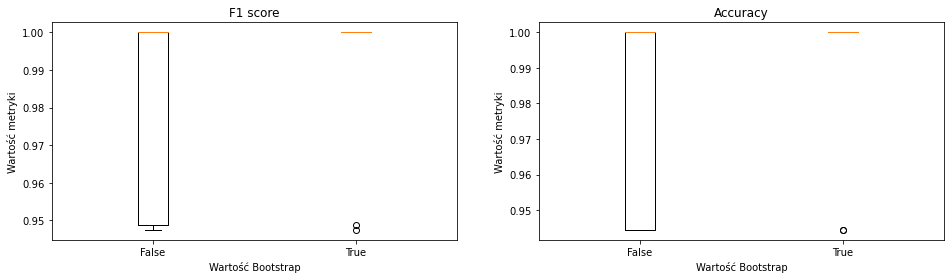

In [23]:
best_n_estimators_bag, best_max_samples_bag, best_max_features_bag, best_bootstrap_bag = run_bagging_experiments(X_wine, y_wine)

## Boosting

N estimators experiment. Other config: learning_rate: 1.0


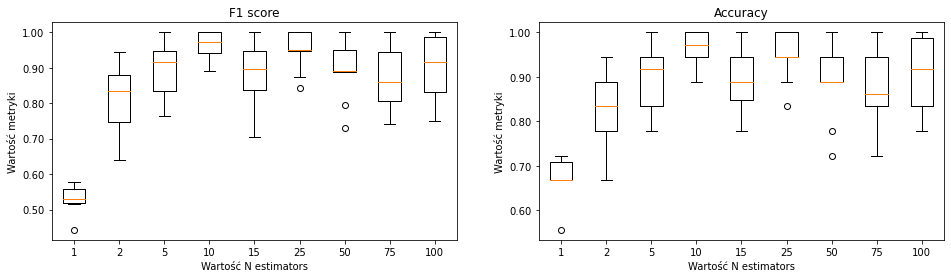

Learning rate experiment. Other config: n_estimators: 10


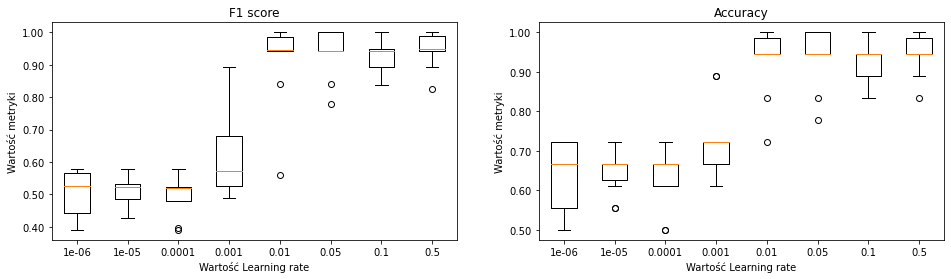

In [24]:
best_n_estimators_boost, best_learning_rate_boost = run_boosting_experiments(X_wine, y_wine)

## Random forest

N estimators experiment. Other config: max_features: sqrt, max_samples: None, max_depth: None


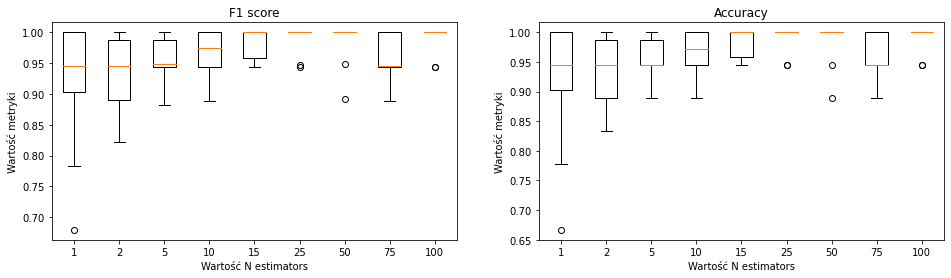

Max features experiment. Other config: n estimators: 25, max_samples: None, max_depth: None


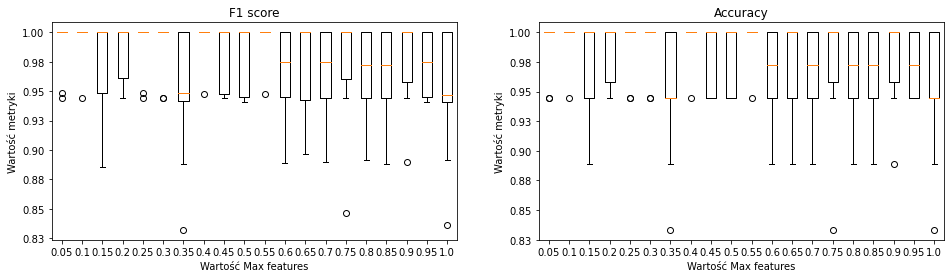

Max samples experiment. Other config: n estimators: 25, max_features: 0.4, max_depth: None


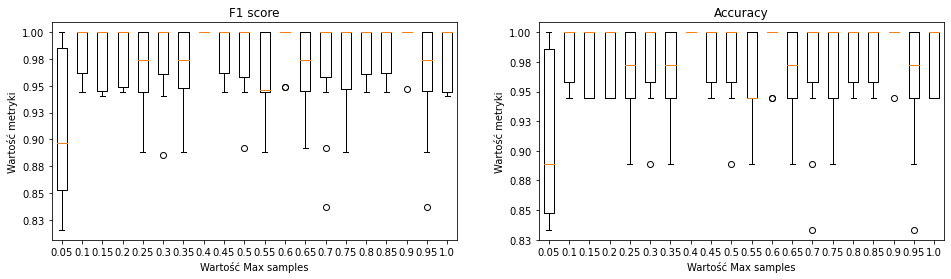

Max depth experiment. Other config: n estimators: 25, max_features: 0.4, max_samples: 0.4


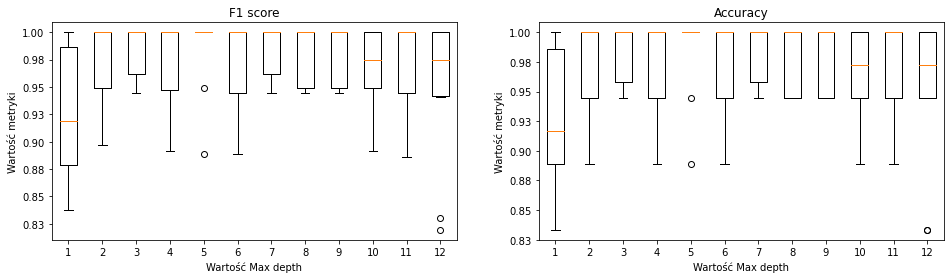

In [25]:
best_n_estimators_forest, best_max_features_forest, best_max_samples_forest, best_max_depth_forest = run_forest_experiments(X_wine, y_wine)

## Porównanie

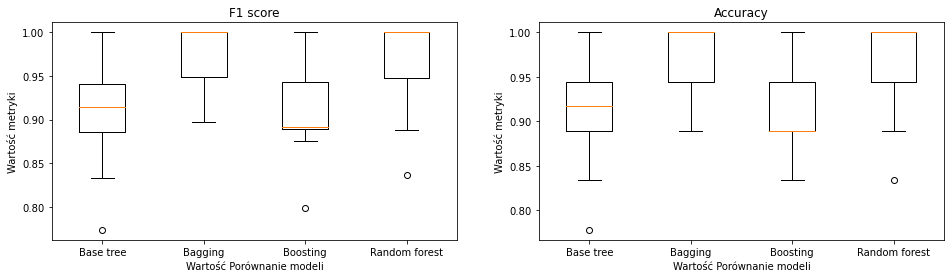

In [26]:
comparison(X_wine, y_wine,
              best_max_depth_tree, best_max_features_tree,
              best_n_estimators_bag, best_max_samples_bag, best_max_features_bag, best_bootstrap_bag,
              best_n_estimators_boost, best_learning_rate_boost,
              best_n_estimators_forest, best_max_features_forest, best_max_samples_forest, best_max_depth_forest
              )

# GLASS

### Bazowy

Max depth experiment. Other config: Max_features: auto


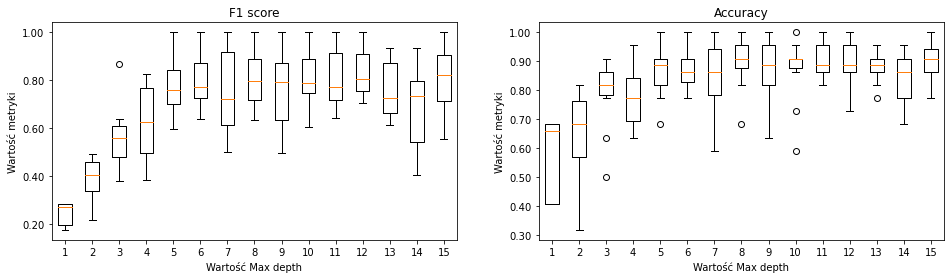

Max_features experiment. Other config: max_depth: 12


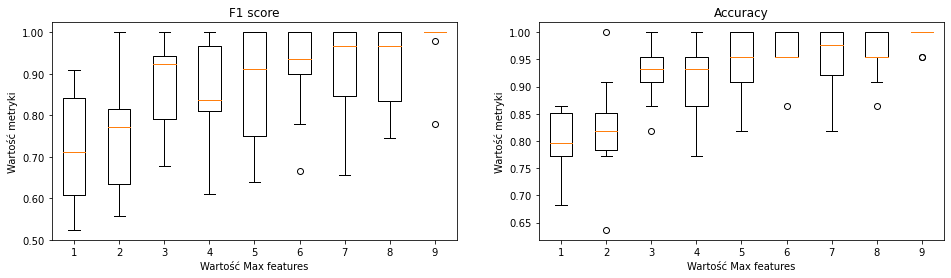

In [27]:
best_max_depth_tree, best_max_features_tree = run_tree_experiments(X_glass, y_glass)

### Bagging

N estimators experiment. Other config: max_samples: 1.0, max_features: 1.0, bootstrap: True


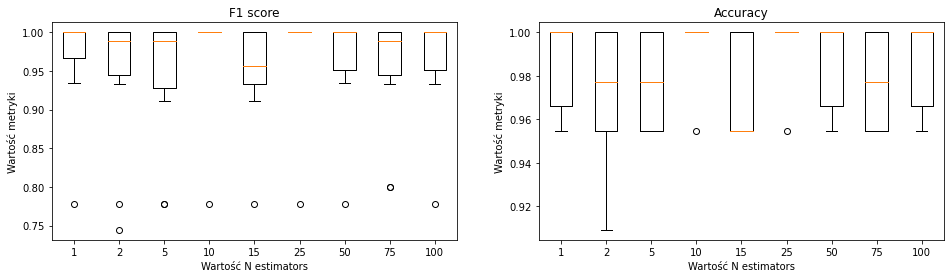

Max_samples experiment. Other config: n_estimators: 10, max_features: 1.0, bootstrap: True


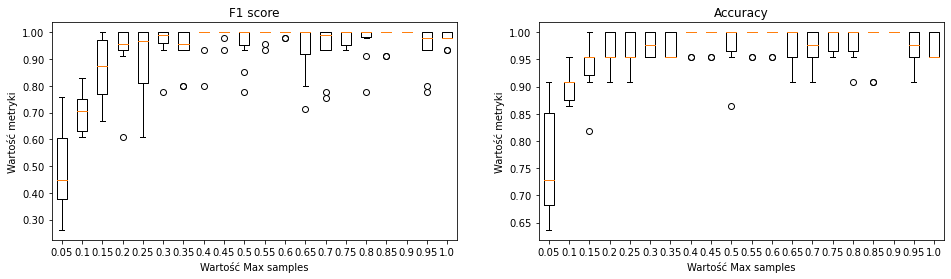

Max_features experiment. Other config: n_estimators: 10, max_samples: 0.9, bootstrap: True


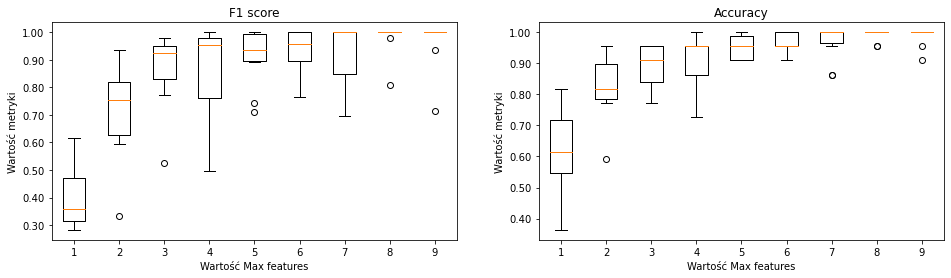

Bootstrap experiment. Other config: n_estimators: 10, max_samples: 0.9, max_features: 8


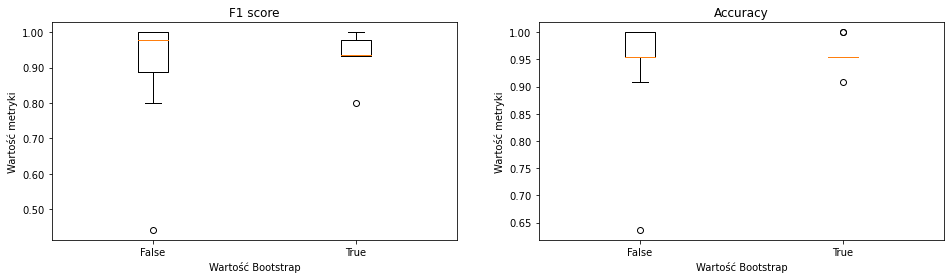

In [28]:
best_n_estimators_bag, best_max_samples_bag, best_max_features_bag, best_bootstrap_bag = run_bagging_experiments(X_glass, y_glass)

### Boosting

N estimators experiment. Other config: learning_rate: 1.0


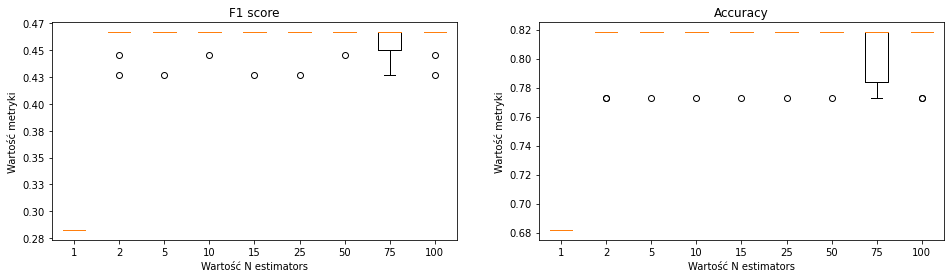

Learning rate experiment. Other config: n_estimators: 10


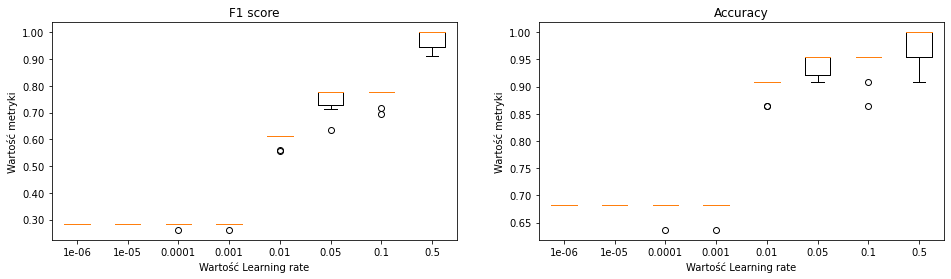

In [29]:
best_n_estimators_boost, best_learning_rate_boost = run_boosting_experiments(X_glass, y_glass)

### Random forest

N estimators experiment. Other config: max_features: sqrt, max_samples: None, max_depth: None


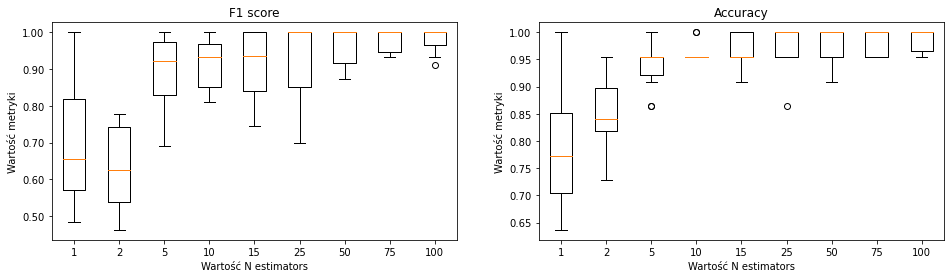

Max features experiment. Other config: n estimators: 100, max_samples: None, max_depth: None


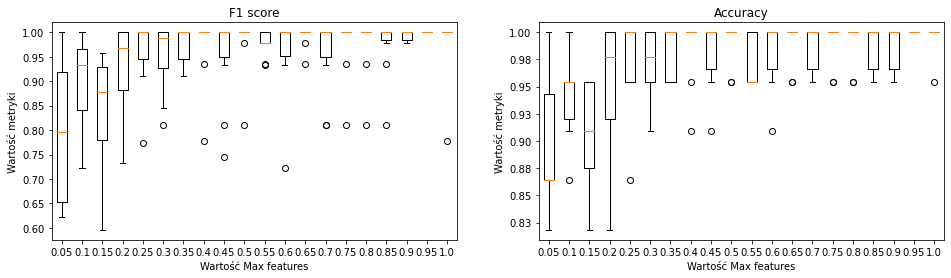

Max samples experiment. Other config: n estimators: 100, max_features: 0.95, max_depth: None


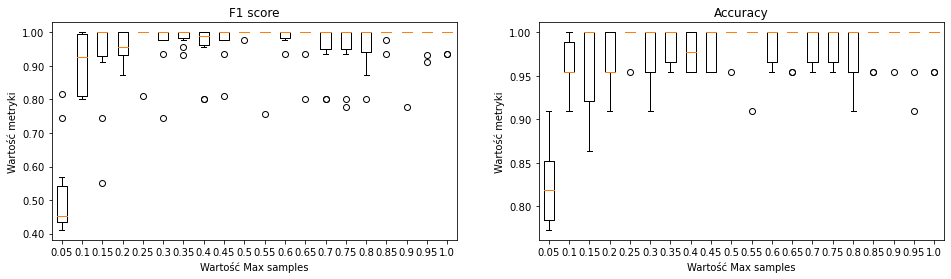

Max depth experiment. Other config: n estimators: 100, max_features: 0.95, max_samples: 0.5


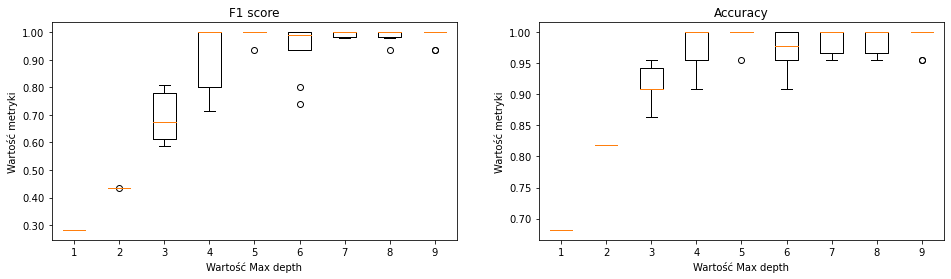

In [30]:
best_n_estimators_forest, best_max_features_forest, best_max_samples_forest, best_max_depth_forest = run_forest_experiments(X_glass, y_glass)

### Porównanie

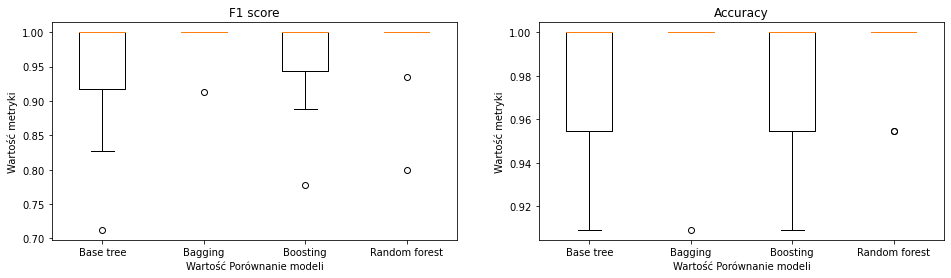

In [31]:
comparison(X_glass, y_glass,
              best_max_depth_tree, best_max_features_tree,
              best_n_estimators_bag, best_max_samples_bag, best_max_features_bag, best_bootstrap_bag,
              best_n_estimators_boost, best_learning_rate_boost,
              best_n_estimators_forest, best_max_features_forest, best_max_samples_forest, best_max_depth_forest
              )

# SEEDS

### Bazowy

Max depth experiment. Other config: Max_features: auto


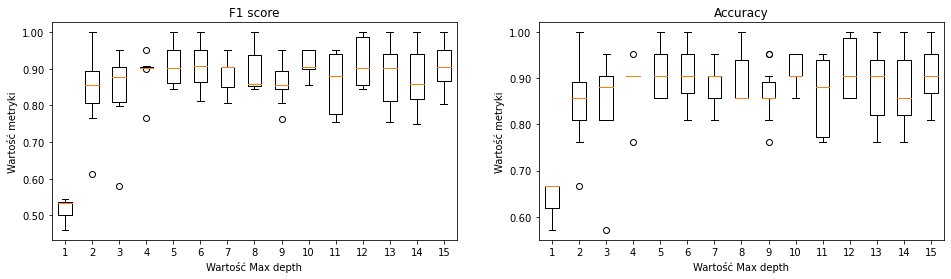

Max_features experiment. Other config: max_depth: 12


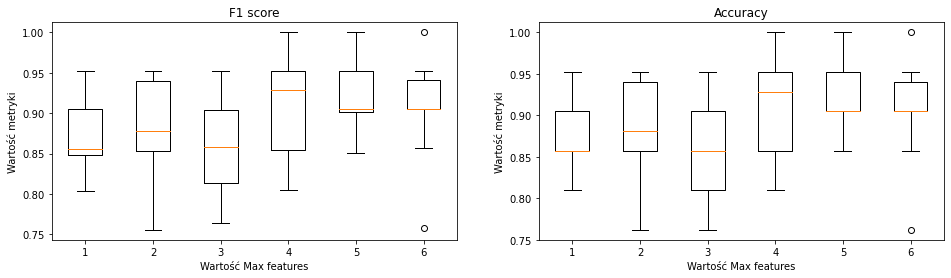

In [32]:
best_max_depth_tree, best_max_features_tree = run_tree_experiments(X_seeds, y_seeds)

### Bagging

N estimators experiment. Other config: max_samples: 1.0, max_features: 1.0, bootstrap: True


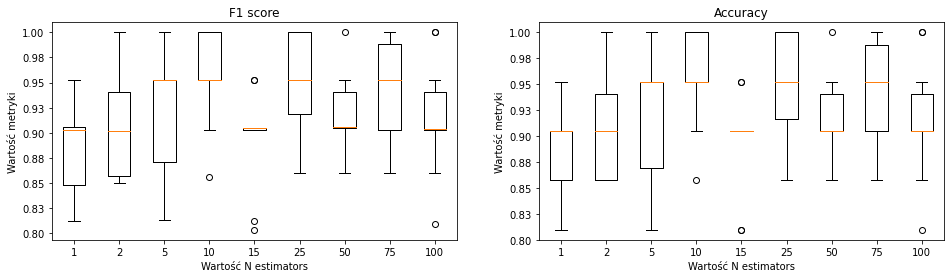

Max_samples experiment. Other config: n_estimators: 10, max_features: 1.0, bootstrap: True


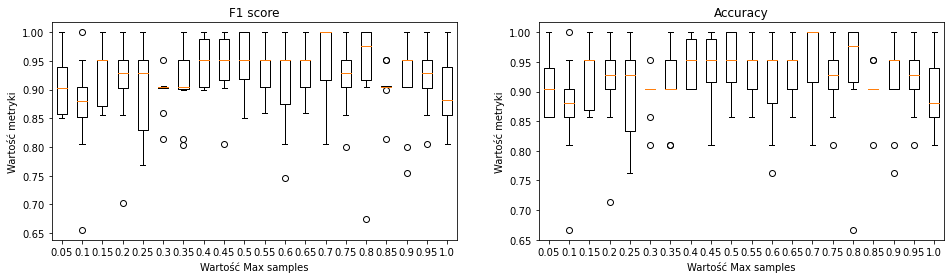

Max_features experiment. Other config: n_estimators: 10, max_samples: 0.7, bootstrap: True


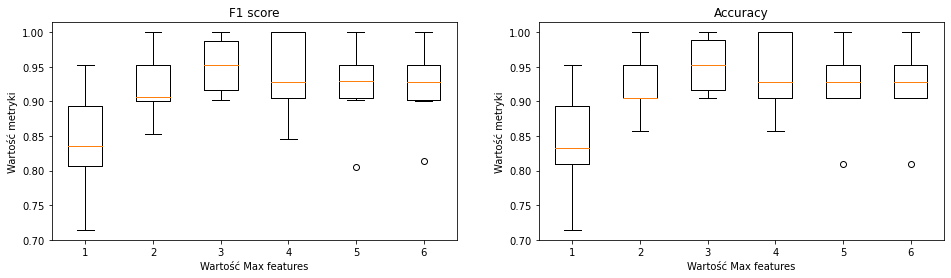

Bootstrap experiment. Other config: n_estimators: 10, max_samples: 0.7, max_features: 3


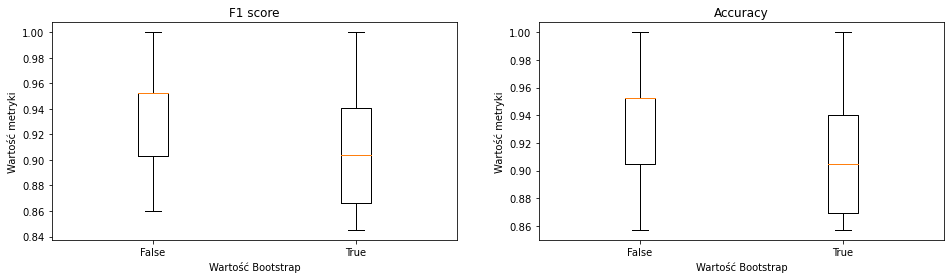

In [33]:
best_n_estimators_bag, best_max_samples_bag, best_max_features_bag, best_bootstrap_bag = run_bagging_experiments(X_seeds, y_seeds)

### Boosting

N estimators experiment. Other config: learning_rate: 1.0


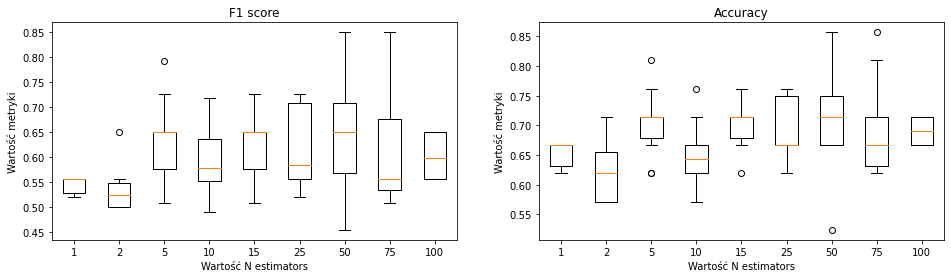

Learning rate experiment. Other config: n_estimators: 50


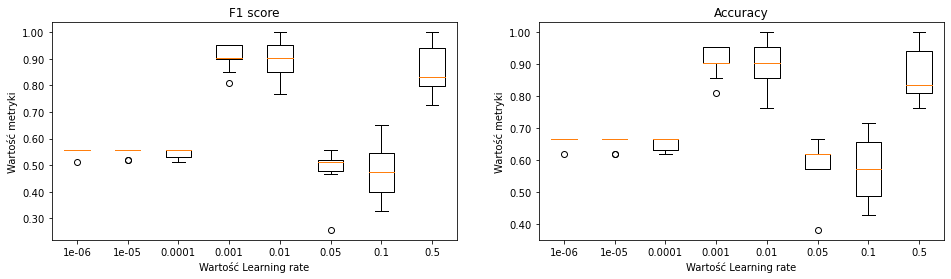

In [34]:
best_n_estimators_boost, best_learning_rate_boost = run_boosting_experiments(X_seeds, y_seeds)

### Random forest

N estimators experiment. Other config: max_features: sqrt, max_samples: None, max_depth: None


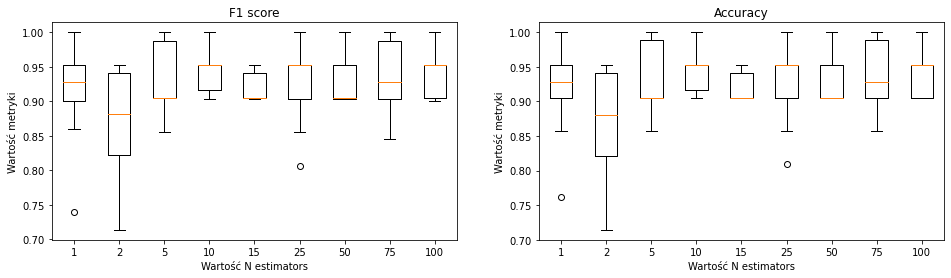

Max features experiment. Other config: n estimators: 10, max_samples: None, max_depth: None


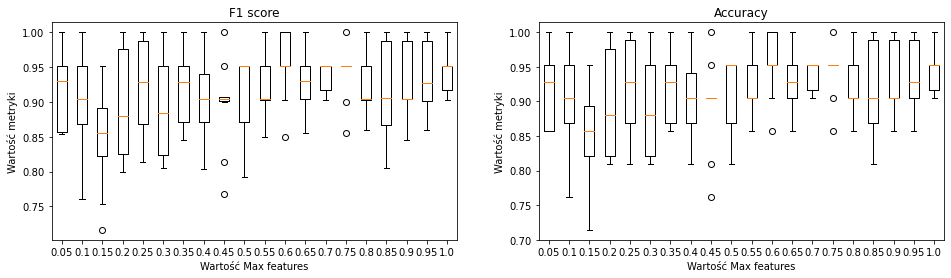

Max samples experiment. Other config: n estimators: 10, max_features: 0.6, max_depth: None


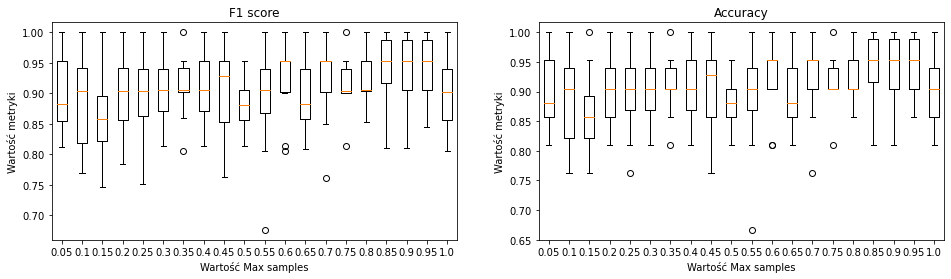

Max depth experiment. Other config: n estimators: 10, max_features: 0.6, max_samples: 0.85


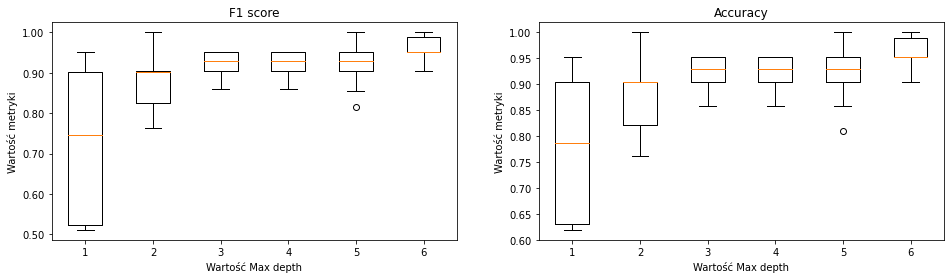

In [35]:
best_n_estimators_forest, best_max_features_forest, best_max_samples_forest, best_max_depth_forest = run_forest_experiments(X_seeds, y_seeds)

### Porównanie

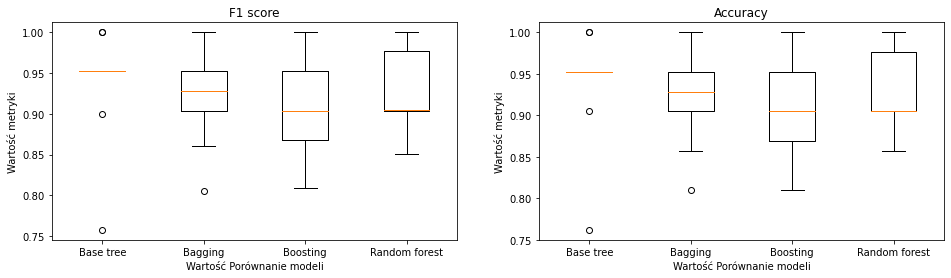

In [36]:
comparison(X_seeds, y_seeds,
              best_max_depth_tree, best_max_features_tree,
              best_n_estimators_bag, best_max_samples_bag, best_max_features_bag, best_bootstrap_bag,
              best_n_estimators_boost, best_learning_rate_boost,
              best_n_estimators_forest, best_max_features_forest, best_max_samples_forest, best_max_depth_forest
              )